# Initial investigation of rework of thesis related to optimizing admittance in a force guided assembly task

In [41]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import random
from matplotlib.collections import PatchCollection
from matplotlib import cm as mcm
import matplotlib.gridspec as gridspec
import math
import logging

In [42]:
logger = logging.getLogger()
logger.setLevel('INFO')

In [43]:
# Define constraints
PENALTYFACTOR=75
INIT_MAX_THETA=np.pi/36
INIT_MIN_THETA=-np.pi/36
INIT_MAX_X=1.87
INIT_MAX_Y=24.5  # Can be scalled depending on part geometry
INIT_MIN_X=-1.87
INIT_MIN_Y=0
DP_INIT=13

xPAPos=2e-1
xPANeg=-2e-1
yPAPos=1e-1
yPANeg=-1e-1
thetaPAPos=0.0872664626
thetaPANeg=-0.0872664626
thresh=1.0e-3

logging.info('Loaded Constants')

INFO:root:Loaded Constants


In [44]:
lb=[INIT_MIN_X,INIT_MIN_Y,INIT_MIN_THETA]
ub=[INIT_MAX_X,INIT_MAX_Y,INIT_MAX_THETA]

In [45]:
# Convinience plotting function
def plot_poly(objs_disp):
  fig, ax = plt.subplots()
  
  patches=[]
  for poly in objs_disp:
    patches.append(poly)
  p=PatchCollection(patches, edgecolor="k", alpha=0.5, cmap=mcm.jet)
  colors = 100*np.random.random(len(patches))
  p.set_array(colors)
  ax.add_collection(p)
  ax.autoscale_view()
  ax.set_aspect('equal','box')
  plt.show()


def plot_shape(shapes):
  fig, ax = plt.subplots()
  for shape in shapes:
    ax.add_patch(shape)
  ax.autoscale_view()
  ax.set_aspect('equal','box')
  plt.show()

We are a bit lazy so we go ahead and define the vertices for the objects here, this was done to save time with parsing dxf files.

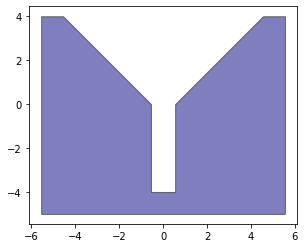

In [46]:
VertA=np.array([
[-5.55, 4],
[-5.55, -5],
[5.55, -5],
[5.55, 4 ],
[4.55, 4],
[0.55, 0],
[0.55, -4],
[-0.55, -4],
[-0.55, 0],
[-4.55, 4 ]
])

figObjA=mpatches.Polygon(VertA)
plot_poly([figObjA])

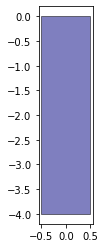

In [47]:
VertB=[
[0.5, -4],
[-0.5, -4],
[-0.5, 0],
[0.5, 0],
]

figObjB=mpatches.Polygon(VertB)
plot_poly([figObjB])

Now we can see the end result of the assembly task, a square peg inside a slot

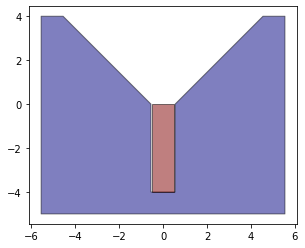

In [48]:
plot_poly([figObjA, figObjB])

Since we are doing a bunch of transformations we are using shapely instead

In [49]:
from shapely.geometry import Polygon, LineString, LinearRing
from descartes import PolygonPatch

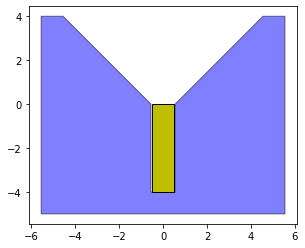

In [50]:
polygonA = Polygon(VertA)
patchA = PolygonPatch(polygonA, fc="b", alpha=0.5)
polygonB = Polygon(VertB)
patchB = PolygonPatch(polygonB, fc="y")
plot_shape([patchA, patchB])

Get all the normals of the lines

In [51]:
def prepare_object(Vert):
  #Check that object is defined as ccw
  LRObjB=LinearRing(Vert)
  if LRObjB.is_ccw is not True:
    Vert=[x for x in reversed(Vert)]
  Lines=[]
  Vectors=[]
  VectorsNorm=[]
  Edges=[]
  Verts2=[]

  # For each create an edge, a shapely line and also due to how we want iterate
  # rework our Vertices to mantain the shape. Normalize our Vectors
  for i in range(len(Vert)):
    Edge=[Vert[i-1],Vert[i]]
    Edges.append(Edge)
    Line=LineString([Vert[i-1],Vert[i]])
    Lines.append(Line)
    Verts2.append(Vert[i-1])
    Vector=np.array(Vert[i-1])-np.array(Vert[i])
    Vectors.append(Vector)
    VectorNorm = Vector/np.linalg.norm(Vector)
    VectorsNorm.append(VectorNorm)

  print("Edges")
  print('\n'.join('{}: {}'.format(*k) for k in enumerate(Edges)))

  print("Vertices")
  print('\n'.join('{}: {}'.format(*k) for k in enumerate(Verts2)))

  # Get the vectors of each 2D object.Super easy for 2D 
  Normals=[]
  for V in VectorsNorm:
    Norm=np.array([-V[1],V[0]])
    Normals.append(Norm)

  print("Normals")
  print('\n'.join('{}: {}'.format(*k) for k in enumerate(Normals)))

  print("Vectors")
  print('\n'.join('{}: {}'.format(*k) for k in enumerate(Vectors)))
  print("Vectors Normalized")
  print('\n'.join('{}: {}'.format(*k) for k in enumerate(VectorsNorm)))
  Obj={}
  Obj['Vertices']=np.asarray(Verts2)
  Obj['Edges']=Edges
  Obj['Lines']=Lines
  Obj['Vectors']=Vectors
  Obj['VectorsNorm']=VectorsNorm
  Obj['Normals']=Normals
  return Obj

In [52]:
ObjA=prepare_object(VertA)

Edges
0: [array([-4.55,  4.  ]), array([-5.55,  4.  ])]
1: [array([-5.55,  4.  ]), array([-5.55, -5.  ])]
2: [array([-5.55, -5.  ]), array([ 5.55, -5.  ])]
3: [array([ 5.55, -5.  ]), array([5.55, 4.  ])]
4: [array([5.55, 4.  ]), array([4.55, 4.  ])]
5: [array([4.55, 4.  ]), array([0.55, 0.  ])]
6: [array([0.55, 0.  ]), array([ 0.55, -4.  ])]
7: [array([ 0.55, -4.  ]), array([-0.55, -4.  ])]
8: [array([-0.55, -4.  ]), array([-0.55,  0.  ])]
9: [array([-0.55,  0.  ]), array([-4.55,  4.  ])]
Vertices
0: [-4.55  4.  ]
1: [-5.55  4.  ]
2: [-5.55 -5.  ]
3: [ 5.55 -5.  ]
4: [5.55 4.  ]
5: [4.55 4.  ]
6: [0.55 0.  ]
7: [ 0.55 -4.  ]
8: [-0.55 -4.  ]
9: [-0.55  0.  ]
Normals
0: [-0.  1.]
1: [-1.  0.]
2: [-0. -1.]
3: [1. 0.]
4: [-0.  1.]
5: [-0.70710678  0.70710678]
6: [-1.  0.]
7: [-0.  1.]
8: [1. 0.]
9: [0.70710678 0.70710678]
Vectors
0: [1. 0.]
1: [0. 9.]
2: [-11.1   0. ]
3: [ 0. -9.]
4: [1. 0.]
5: [4. 4.]
6: [0. 4.]
7: [1.1 0. ]
8: [ 0. -4.]
9: [ 4. -4.]
Vectors Normalized
0: [1. 0.]
1: [0. 

In [53]:
ObjB=prepare_object(VertB)

Edges
0: [[0.5, -4], [0.5, 0]]
1: [[0.5, 0], [-0.5, 0]]
2: [[-0.5, 0], [-0.5, -4]]
3: [[-0.5, -4], [0.5, -4]]
Vertices
0: [0.5, -4]
1: [0.5, 0]
2: [-0.5, 0]
3: [-0.5, -4]
Normals
0: [1. 0.]
1: [-0.  1.]
2: [-1.  0.]
3: [-0. -1.]
Vectors
0: [ 0. -4.]
1: [1. 0.]
2: [0. 4.]
3: [-1.  0.]
Vectors Normalized
0: [ 0. -1.]
1: [1. 0.]
2: [0. 1.]
3: [-1.  0.]


Define our edges and also our vectors and normalize them

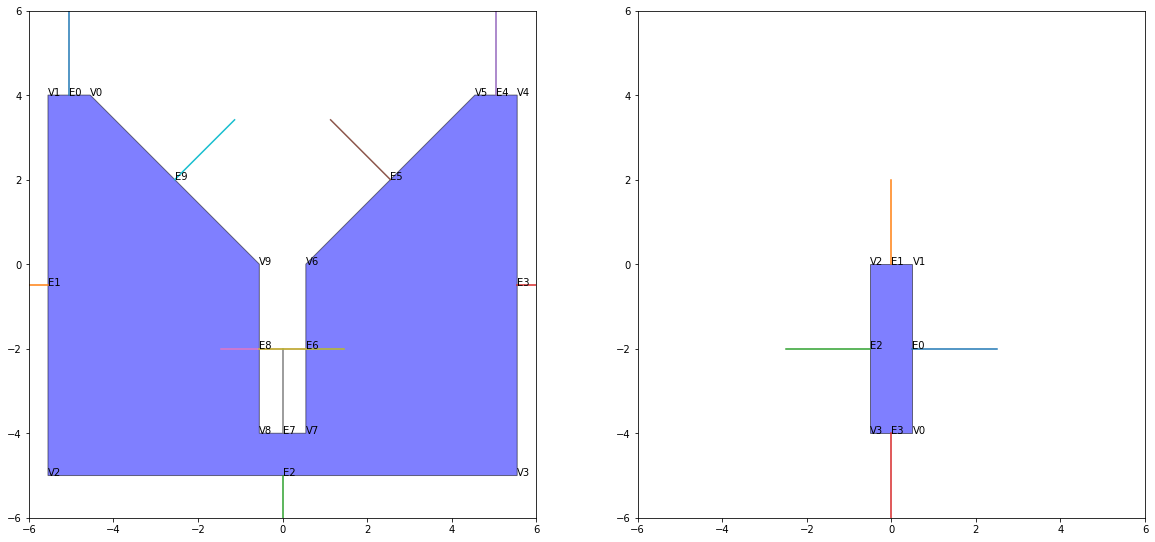

In [54]:
fig, axs= plt.subplots(1,2, figsize=(20,20))

ax=axs[0]
polygonA = Polygon(ObjA['Vertices'])
patchA = PolygonPatch(polygonA, fc="b", alpha=0.5)

for i,(e,n) in enumerate(zip(ObjA['Edges'], ObjA['Normals'])):
  mdpt=(np.add(e[0],e[1]))/2
  ax.text(mdpt[0],mdpt[1],'E{}'.format(i))
  scnd=mdpt+n*2
  L=LineString([mdpt, scnd])
  x,y=L.xy
  ax.plot(x,y)

for n, (x,y) in enumerate(ObjA['Vertices']):
  ax.text(x,y,'V{}'.format(n))

ax.add_patch(patchA)
ax.autoscale_view()
ax.set_aspect('equal','box')
ax.set_xbound(-6,6)
ax.set_ybound(-6,6)

polygonB = Polygon(ObjB['Vertices'])
patchB = PolygonPatch(polygonB, fc="b", alpha=0.5)

ax= axs[1]

for i,(e,n) in enumerate(zip(ObjB['Edges'], ObjB['Normals'])):
  mdpt=np.add(e[0],e[1])/2
  ax.text(mdpt[0],mdpt[1],'E{}'.format(i))
  scnd=mdpt+n*2
  L=LineString([mdpt, scnd])
  x,y=L.xy
  ax.plot(x,y)

for n, (x,y) in enumerate(ObjB['Vertices']):
  ax.text(x,y,'V{}'.format(n))

ax.add_patch(patchB)
ax.autoscale_view()
ax.set_aspect('equal','box')

ax.set_xbound(-6,6)
ax.set_ybound(-6,6)

plt.show()


In [55]:
def get_concave(ObjData):
    ConcaveList=[]
    for i in range(len(ObjData['Vertices'])):
        x1=np.take(ObjData['Vertices'],i, axis=0, mode='wrap')

        be1=np.take(ObjData['Normals'],i-1, axis=0, mode='wrap')
        be2=np.take(ObjData['Normals'],i, axis=0, mode='wrap')

        be1=np.append(be1,0)
        be2=np.append(be2,0)

        v=np.cross(be1,be2)

        v0=np.append(x1,0)
        v2=np.append(x1,-1)

        res=np.dot(-v, (v2- v0))

        ConcaveList.append(res)
    return ConcaveList

In [56]:
ConcaveListA=get_concave(ObjA)
ConcaveListB=get_concave(ObjB)

ObjA['Concave']=ConcaveListA
ObjB['Concave']=ConcaveListB

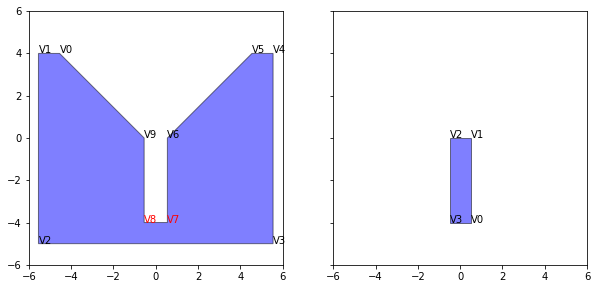

In [57]:
fig, axs= plt.subplots(1,2, sharey=True, figsize=(10,10))

ax=axs[0]
polygonA = Polygon(ObjA['Vertices'])
patchA = PolygonPatch(polygonA, fc="b", alpha=0.5)

for n, ((x,y),Clist) in enumerate(zip(ObjA['Vertices'],ConcaveListA)):
    if Clist<=0:
        ax.text(x,y,'V{}'.format(n),color='red')
    else:
        ax.text(x,y,'V{}'.format(n))



ax1=axs[1]
polygonB = Polygon(ObjB['Vertices'])
patchB = PolygonPatch(polygonB, fc="b", alpha=0.5)

for n, ((x,y),Clist) in enumerate(zip(ObjB['Vertices'],ConcaveListB)):
    if Clist<=0:
        ax1.text(x,y,'V{}'.format(n),color='red')
    else:
        ax1.text(x,y,'V{}'.format(n))

ax1.add_patch(patchB)
ax1.set_aspect('equal')

ax.add_patch(patchA)

ax.set_xbound(-6,6)
ax.set_ybound(-6,6)
ax1.set_xbound(-6,6)
ax1.set_ybound(-6,6)


ax.set_aspect('equal')

## Vertex Edge Contacts

We check for ObjA V and ObjB E.

In [58]:
def get_angle_vector(a,b):
    a1=np.arccos(a[0]/np.linalg.norm(a))
    a2=np.arccos(b[0]/np.linalg.norm(b))

    if a[1]<0:
        a1=-a1

    if b[1]<0:
        a2=-a2

    angle=a1-a2

    if angle>np.pi:
        angle=angle-2*np.pi
    elif angle<=-np.pi:
        angle=angle+2*np.pi

    return angle

In [59]:
def VE_feas(Angle_a, Angle_b):
    a_max=np.max([Angle_a, Angle_b])
    a_min=np.min([Angle_a, Angle_b])

    if a_max-a_min > np.pi:
        temp=a_max
        a_max=a_min+2*np.pi
        a_min=temp

    if a_max<INIT_MIN_THETA or a_min>INIT_MAX_THETA:
        feas=False
    else:
        feas=True
    return a_min, a_max, feas

In [60]:
ContactStates=[]
for iA, (vA, cl) in enumerate(zip(ObjA['Vertices'], ObjA['Concave'])):
    if cl>0:
        Ea=ObjA['Normals'][iA]
        Eb=ObjA['Normals'][iA-1]

        for iB, NB in enumerate(ObjB['Normals']):
            temp=-NB
            Angle_a=get_angle_vector(Ea, temp)
            Angle_b=get_angle_vector(Eb, temp)
            a_min, a_max, feas=VE_feas(Angle_a, Angle_b)
            if feas:
                print('V {}, E{}, Angle_Min {}, Angle_Max {}'.format(iA, iB,
                math.degrees(a_min), math.degrees(a_max)))
                cs={'Type':'V-E',
                    'ID':'V{}-E{}'.format(iA, iB),
                    'ElementA':vA,
                    'ElementB':ObjB['Edges'][iB],
                    'a_min':a_min,
                    'a_max':a_max}
                ContactStates.append(cs)

            

        

V 0, E3, Angle_Min -45.0, Angle_Max 0.0
V 1, E0, Angle_Min -90.0, Angle_Max 0.0
V 1, E3, Angle_Min 0.0, Angle_Max 90.0
V 2, E0, Angle_Min 0.0, Angle_Max 90.0
V 2, E1, Angle_Min -90.0, Angle_Max 0.0
V 3, E1, Angle_Min 0.0, Angle_Max 90.0
V 3, E2, Angle_Min -90.0, Angle_Max 0.0
V 4, E2, Angle_Min 0.0, Angle_Max 90.0
V 4, E3, Angle_Min -90.0, Angle_Max 0.0
V 5, E3, Angle_Min 0.0, Angle_Max 45.0
V 6, E0, Angle_Min -45.0, Angle_Max 0.0
V 9, E2, Angle_Min 0.0, Angle_Max 45.0


In [104]:
conf=[]
for l,u in zip(lb,ub):
    conf.append(random.uniform(l, u))
    

In [143]:
print('Lower:',lb)
print('Upper:',ub)
conf[2]=math.radians(-10)
print('Conf:',conf[:2],math.degrees(conf[2]))


Lower: [-1.87, 0, -0.08726646259971647]
Upper: [1.87, 24.5, 0.08726646259971647]
Conf: [1.2521116438226687, 12.93470617886232] -10.0


In [144]:
def transfer_N(pt, conf):
    trans=conf[0:1]
    angle=conf[2]
    c, s = np.cos(angle), np.sin(angle)
    R = np.array(((c, -s), (s, c)))
    npt=np.dot(R,pt)+trans
    return npt

def mu_f(x):
    if x<-1E-3:
        val=abs(x)
    else:
        val=0
    return val

In [145]:
Ao=cs['ElementB'][0]
Bo=cs['ElementB'][1]

A=transfer_N(Ao, conf)
B=transfer_N(Bo, conf)

normalLength=np.linalg.norm(A-B)

In [146]:
P=cs['ElementA']

In [147]:
v1=P-A
v2=B-A
h1=abs(np.cross(v1,v2))/normalLength

In [148]:
v1p=np.append(v1,0)
v2p=np.append(v2,0)

In [149]:
temp=np.cross(v1p,v2p)
v1c=np.cross(temp,v2p)/np.dot(v2p,v2p)

In [150]:
Pp=P+v1c[:2]

In [154]:
if A[0]-B[0]==0:
    alpha=((Pp[1]-A[1])*normalLength)/(B[1]-A[1])
else:
    alpha=((Pp[0]-A[0])*normalLength)/(B[0]-A[0])

In [155]:
h2=mu_f(alpha)+mu_f(normalLength-alpha)

In [163]:
result=h1+h2

In [164]:
print('h1+h2:',result)

h1+h2: 1.0573066134447882


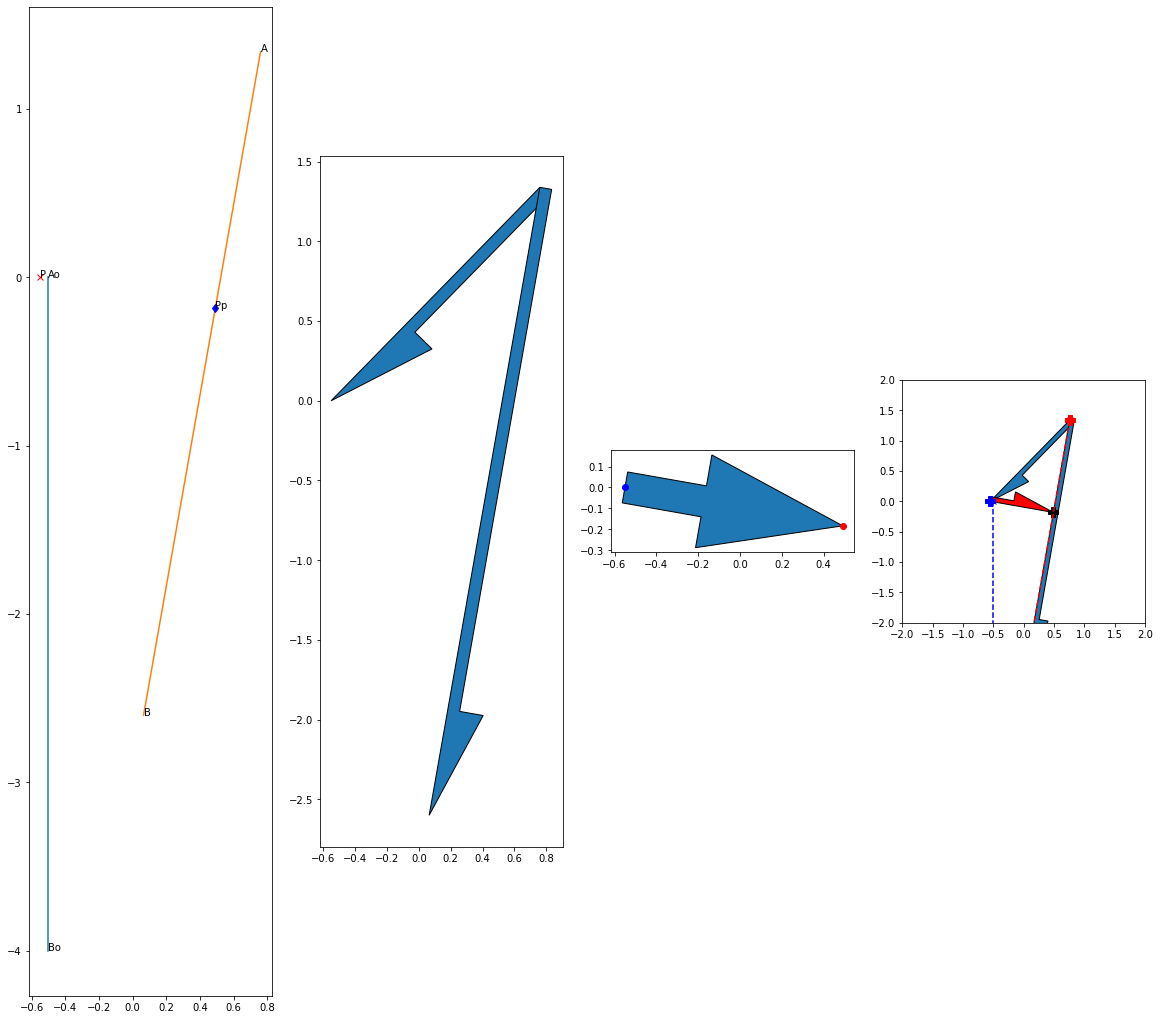

In [153]:
fig, axs = plt.subplots(1,4, figsize=(20,20))
ax1=axs[0]
ax1.plot(P[0],P[1],'rx')
ax1.text(P[0],P[1],'P')

sVo=np.array([Ao,Bo]).T
ax1.plot(sVo[0],sVo[1])
ax1.text(Ao[0],Ao[1],'Ao')
ax1.text(Bo[0],Bo[1],'Bo')

sV=np.array([A,B]).T
ax1.plot(sV[0],sV[1])
ax1.text(A[0],A[1],'A')
ax1.text(B[0],B[1],'B')

ax1.plot(Pp[0],Pp[1],'db')
ax1.text(Pp[0],Pp[1],'Pp')
ax1.set_aspect('equal')

ax2=axs[1]
ax2.arrow(A[0],A[1],v1[0],v1[1],width=0.15, shape='right',length_includes_head=True)
ax2.arrow(A[0],A[1],v2[0],v2[1],width=0.15, shape='right',length_includes_head=True)

ax2.set_aspect('equal')

ax3=axs[2]
ax3.plot(Pp[0],Pp[1],'or')
ax3.plot(P[0],P[1],'ob')
ax3.arrow(P[0],P[1],v1c[0],v1c[1],width=0.15,length_includes_head=True)
ax3.set_aspect('equal')

ax4=axs[3]
ax4.arrow(A[0],A[1],v1[0],v1[1],width=0.15, shape='right',length_includes_head=True)
ax4.arrow(A[0],A[1],v2[0],v2[1],width=0.15, shape='right',length_includes_head=True)
ax4.arrow(P[0],P[1],v1c[0],v1c[1],width=0.15,shape='right',length_includes_head=True, facecolor='r')

ax4.plot(A[0],A[1],'Pr',markersize=10)
ax4.plot(P[0],P[1],'Pb',markersize=10)
ax4.plot(Pp[0],Pp[1],'Pk',markersize=10)

ax4.plot(sV[0],sV[1],'--xr')
ax4.plot(sVo[0],sVo[1],'--xb')
ax4.set_xbound(-2,2)
ax4.set_ybound(-2,2)
ax4.set_aspect('equal')



array([0.        , 0.        , 6.96087113])

In [77]:
P

array([-0.55,  0.  ])

In [78]:
P

array([-0.55,  0.  ])

In [79]:
Pp

array([1.18893628, 0.06677225])

In [80]:
v1c[0:2]

array([1.73893628, 0.06677225])